Loading and unloading of a viscoelastic half-space
======

Loading of Earth's surface can be described with an initial periodic surface displacement of a viscous fluid within an infinite half space, the solution of which is outlined in Turcotte and Schubert (1982), 6-10.  The surface decreases exponentially with time and is dependent on the magnitude, $w_m$, and wavelength $\lambda$ of the perturbation, and the viscosity, $\eta$ and density, $\rho$ of the fluid,

$$ w = w_m exp\Big(\frac{-\lambda \rho g t}{4\pi\eta}\Big) $$

where $w$ is displacement, $w_m$ the initial load magnitude, $g$ gravity, $t$ time. This solution can be charaterised by the relaxation time, $t_{relax} = 4\pi\eta / \rho g \lambda $, the time taken for the initial load to decrease by $e^{-1}$. The solution for an elastic material with the equivalent load produces the same magnitude of displacement instantaneously.


In [1]:
%matplotlib inline
import UWGeodynamics as GEO
import numpy as np

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Analytical solution

In [3]:
# model domain
minX = -200.0e3 * u.meter
maxX =  200.0e3 * u.meter
minY = - 80.0e3 * u.meter
maxY =   20.0e3 * u.meter

# model parameters
density   = 3300 * u.kilogram / u.metre**3 
gravity   = 9.81 * u.meter / u.second**2

In [4]:
# material parameters
eta  = 1e21  * u.pascal * u.second # viscosity of fluid (mantle)
mu   = 9.5e7 * u.pascal           # shear modulus
dt_e = 1e5     * u.year

alpha = eta / mu  # Maxwell relaxation time

eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # for viscoelastic implementation

In [5]:
# Characteristic values of the system
ref_length = 1e5 * u.meter
ref_eta = eta
ref_rho = density
ref_force = density * gravity
ref_time = dt_e / 10

KL = ref_length
Kt = ref_time
KM = ref_force * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [6]:
# Dimensional and dimensionless parameters
print(f"Maxwell relaxation time: {alpha.to(u.year):.2e} | {GEO.nd(alpha):.2f}")
print(f"Observation time:        {dt_e.to(u.year):.2e} | {GEO.nd(dt_e):.2f}")
print(f"effective viscosity:     {eta_eff.to(u.pascal * u.second):.2e} | {GEO.nd(eta_eff):.2f}")

Maxwell relaxation time: 3.34e+05 year | 33.36
Observation time:        1.00e+05 year | 10.00
effective viscosity:     2.31e+20 pascal * second | 0.23


In [7]:
# Initial Load Magnitude and wavelength
w_m    =   5.0 * u.kilometer # displacement magnitue, << Lambda
Lambda = 100.0 * u.kilometer # displacement wavelength

In [8]:
# analytic solution
xMax = maxX - minX
x = np.linspace(0, xMax.magnitude, 200+1)

# initial displacement
w_0 = w_m * np.cos(2.*np.pi*(x*u.meter)/Lambda)

In [9]:
# viscous relaxation of load
t_relax = 4 * np.pi * eta / (Lambda * density * gravity)
tMax = (t_relax * 5).to_base_units()

# deflection with time of viscous solution
t = np.linspace(0, tMax.magnitude, 100 * 10 + 1)
t *= u.second
w_t = w_m * np.exp(-1.*t/t_relax)

# Scaling

In [10]:
Model = GEO.Model(elementRes=(128, 32),
                  minCoord=(minX, minY),
                  maxCoord=(maxX, maxY),
                  periodic=[True, False], 
                  gravity=[0., -1.0 * gravity])

In [11]:
Model.outputDir="1_08_ViscoElasticHalfSpace"

## Materials

In [12]:
air = Model.add_material(name="Air")
mantle = Model.add_material(name="Mantle")

In [13]:
import underworld.function as fn

coords = fn.input()
perturbation = GEO.nd(w_m) * fn.math.cos(2. * np.pi * coords[0] / GEO.nd(Lambda))

conditions = [(coords[1] < perturbation, mantle.index),
              (True, air.index)]
                                        
Model.materialField.data[:] = fn.branching.conditional(conditions).evaluate(Model.swarm)

## Densities

In [14]:
air.density = 0.1 * u.kilogram / u.meter**3
mantle.density = 3300 * u.kilogram / u.metre**3 

## Viscosities

In [15]:
air.viscosity = 1e18 * u.pascal * u.second
mantle.viscosity = 1e21 * u.pascal * u.second

In [16]:
mantle.elasticity = GEO.Elasticity(shear_modulus=mu, 
                                   observation_time=dt_e)

## Velocity Boundary conditions

In [17]:
Model.set_velocityBCs(top=[0,0], bottom=[0,0])

## Passive Tracers

In [18]:
import numpy as np
coords = np.ndarray((1, 2))
coords[:, 1] = GEO.nd(w_m)
coords
tracerSolo = Model.add_passive_tracers(name="Single Tracer", 
                                       vertices=coords[0])

## Visualisation


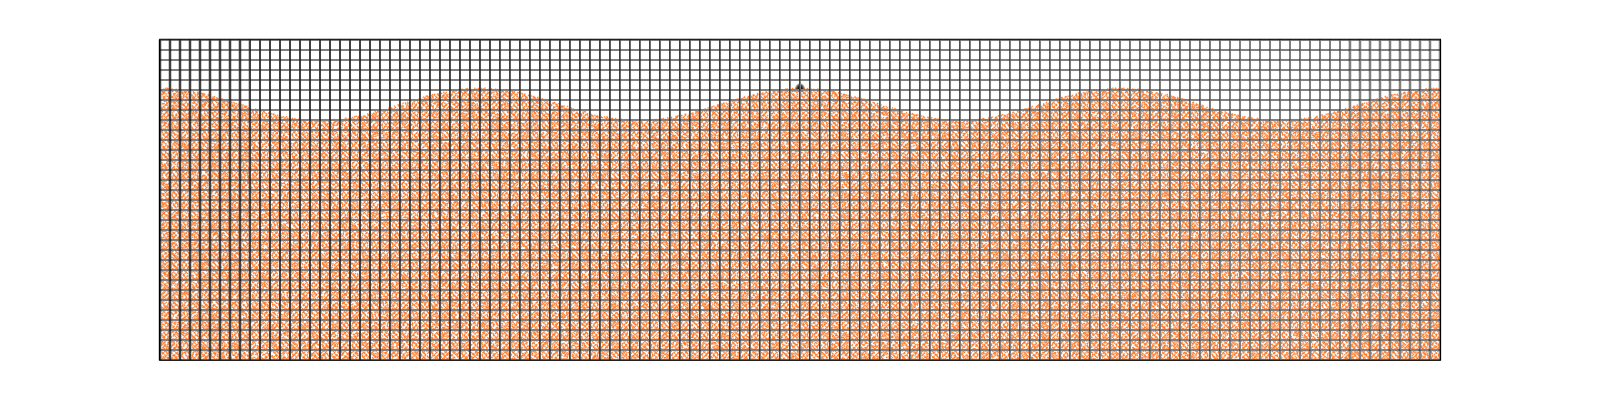

In [19]:
from UWGeodynamics import visualisation as vis

materialFilter = Model.materialField > 1

figMaterial = vis.Figure(figsize=(1600,400))
figMaterial.Mesh(Model.mesh,opacity=0.5)
figMaterial.Points(tracerSolo, pointSize=10, colourBar=False)
figMaterial.Points(Model.swarm, Model.materialField, fn_mask=materialFilter, 
                   pointSize=2, colourBar=False, valueRange=[0,1])
figMaterial.save("Figure_1.png")
figMaterial.show()

In [20]:
Model.solver.set_inner_method("lu")

In [21]:
tTracer      = [GEO.nd(Model.time)]
displacement = [GEO.nd(tracerSolo.particleCoordinates.data[0][1])]

def postSolveHook():
    global tTracer, displacement
    tTracer.append(GEO.nd(Model.time))
    displacement.append(GEO.nd(tracerSolo.particleCoordinates.data[0][1]))

In [22]:
Model.post_solve_functions['tracer_analysis'] = postSolveHook

In [23]:
Model.run_for(duration=tMax, dt=1e-2*t_relax)

Running with UWGeodynamics version 2.9.5
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 1230.1 year dt: 1230.1 year (2020-07-01 11:11:41)
Step:     2 Model Time: 2460.2 year dt: 1230.1 year (2020-07-01 11:11:43)
Step:     3 Model Time: 3690.2 year dt: 1230.1 year (2020-07-01 11:11:44)
Step:     4 Model Time: 4920.3 year dt: 1230.1 year (2020-07-01 11:11:46)
Step:     5 Model Time: 6150.4 year dt: 1230.1 year (2020-07-01 11:11:47)
Step:     6 Model Time: 7380.5 year dt: 1230.1 year (2020-07-01 11:11:49)
Step:     7 Model Time: 8610.5 year dt: 1230.1 year (2020-07-01 11:11:50)
Step:     8 Model Time: 9840.6 year dt: 1230.1 year (2020-07-01 11:11:52)
Step:     9 Model Time: 11070.7 year dt: 1230.1 year (2

Step:   106 Model Time: 130388.1 year dt: 1230.1 year (2020-07-01 11:15:21)
Step:   107 Model Time: 131618.2 year dt: 1230.1 year (2020-07-01 11:15:23)
Step:   108 Model Time: 132848.3 year dt: 1230.1 year (2020-07-01 11:15:25)
Step:   109 Model Time: 134078.4 year dt: 1230.1 year (2020-07-01 11:15:28)
Step:   110 Model Time: 135308.4 year dt: 1230.1 year (2020-07-01 11:15:29)
Step:   111 Model Time: 136538.5 year dt: 1230.1 year (2020-07-01 11:15:31)
Step:   112 Model Time: 137768.6 year dt: 1230.1 year (2020-07-01 11:15:33)
Step:   113 Model Time: 138998.7 year dt: 1230.1 year (2020-07-01 11:15:34)
Step:   114 Model Time: 140228.8 year dt: 1230.1 year (2020-07-01 11:15:36)
Step:   115 Model Time: 141458.8 year dt: 1230.1 year (2020-07-01 11:15:38)
Step:   116 Model Time: 142688.9 year dt: 1230.1 year (2020-07-01 11:15:40)
Step:   117 Model Time: 143919.0 year dt: 1230.1 year (2020-07-01 11:15:42)
Step:   118 Model Time: 145149.1 year dt: 1230.1 year (2020-07-01 11:15:44)
Step:   119 

Step:   214 Model Time: 263236.4 year dt: 1230.1 year (2020-07-01 11:18:44)
Step:   215 Model Time: 264466.5 year dt: 1230.1 year (2020-07-01 11:18:46)
Step:   216 Model Time: 265696.6 year dt: 1230.1 year (2020-07-01 11:18:47)
Step:   217 Model Time: 266926.7 year dt: 1230.1 year (2020-07-01 11:18:49)
Step:   218 Model Time: 268156.7 year dt: 1230.1 year (2020-07-01 11:18:50)
Step:   219 Model Time: 269386.8 year dt: 1230.1 year (2020-07-01 11:18:52)
Step:   220 Model Time: 270616.9 year dt: 1230.1 year (2020-07-01 11:18:54)
Step:   221 Model Time: 271847.0 year dt: 1230.1 year (2020-07-01 11:18:56)
Step:   222 Model Time: 273077.0 year dt: 1230.1 year (2020-07-01 11:18:59)
Step:   223 Model Time: 274307.1 year dt: 1230.1 year (2020-07-01 11:19:01)
Step:   224 Model Time: 275537.2 year dt: 1230.1 year (2020-07-01 11:19:03)
Step:   225 Model Time: 276767.3 year dt: 1230.1 year (2020-07-01 11:19:05)
Step:   226 Model Time: 277997.4 year dt: 1230.1 year (2020-07-01 11:19:07)
Step:   227 

Step:   322 Model Time: 396084.7 year dt: 1230.1 year (2020-07-01 11:22:07)
Step:   323 Model Time: 397314.8 year dt: 1230.1 year (2020-07-01 11:22:09)
Step:   324 Model Time: 398544.9 year dt: 1230.1 year (2020-07-01 11:22:11)
Step:   325 Model Time: 399775.0 year dt: 1230.1 year (2020-07-01 11:22:14)
Step:   326 Model Time: 401005.0 year dt: 1230.1 year (2020-07-01 11:22:16)
Step:   327 Model Time: 402235.1 year dt: 1230.1 year (2020-07-01 11:22:18)
Step:   328 Model Time: 403465.2 year dt: 1230.1 year (2020-07-01 11:22:21)
Step:   329 Model Time: 404695.3 year dt: 1230.1 year (2020-07-01 11:22:23)
Step:   330 Model Time: 405925.3 year dt: 1230.1 year (2020-07-01 11:22:25)
Step:   331 Model Time: 407155.4 year dt: 1230.1 year (2020-07-01 11:22:28)
Step:   332 Model Time: 408385.5 year dt: 1230.1 year (2020-07-01 11:22:30)
Step:   333 Model Time: 409615.6 year dt: 1230.1 year (2020-07-01 11:22:32)
Step:   334 Model Time: 410845.6 year dt: 1230.1 year (2020-07-01 11:22:35)
Step:   335 

Step:   430 Model Time: 528933.0 year dt: 1230.1 year (2020-07-01 11:26:15)
Step:   431 Model Time: 530163.1 year dt: 1230.1 year (2020-07-01 11:26:17)
Step:   432 Model Time: 531393.2 year dt: 1230.1 year (2020-07-01 11:26:19)
Step:   433 Model Time: 532623.3 year dt: 1230.1 year (2020-07-01 11:26:21)
Step:   434 Model Time: 533853.3 year dt: 1230.1 year (2020-07-01 11:26:23)
Step:   435 Model Time: 535083.4 year dt: 1230.1 year (2020-07-01 11:26:25)
Step:   436 Model Time: 536313.5 year dt: 1230.1 year (2020-07-01 11:26:27)
Step:   437 Model Time: 537543.6 year dt: 1230.1 year (2020-07-01 11:26:29)
Step:   438 Model Time: 538773.6 year dt: 1230.1 year (2020-07-01 11:26:31)
Step:   439 Model Time: 540003.7 year dt: 1230.1 year (2020-07-01 11:26:33)
Step:   440 Model Time: 541233.8 year dt: 1230.1 year (2020-07-01 11:26:35)
Step:   441 Model Time: 542463.9 year dt: 1230.1 year (2020-07-01 11:26:37)
Step:   442 Model Time: 543693.9 year dt: 1230.1 year (2020-07-01 11:26:39)
Step:   443 

1


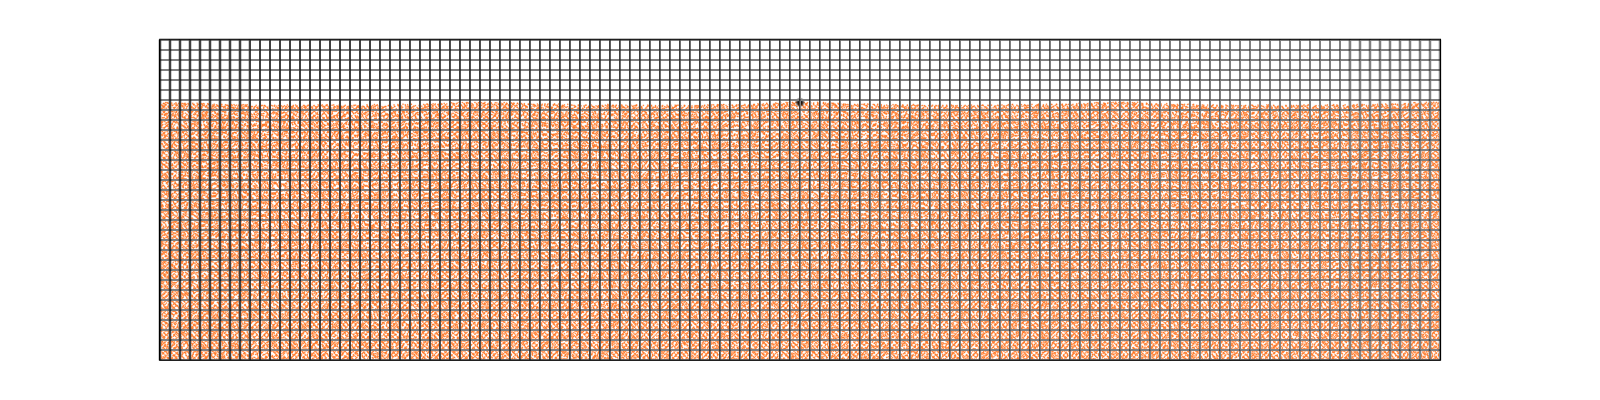

In [24]:
figMaterial.save("Figure_2.png")
figMaterial.show()

# Analysis

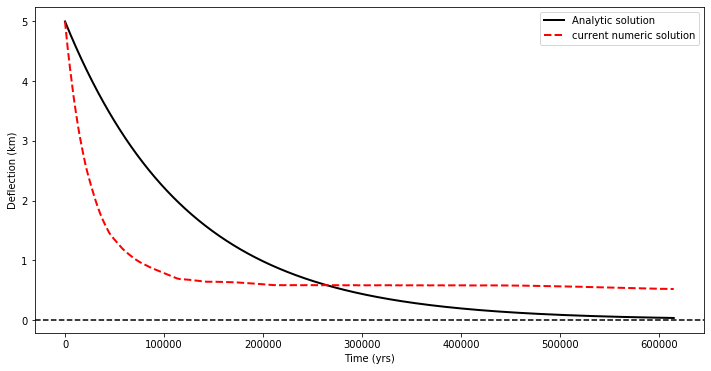

In [30]:
import pylab as plt

fig, (ax) = plt.subplots(1, 1)
fig.set_size_inches(12, 6) 
ax.plot(t.m_as(u.years), w_t.m_as(u.kilometer),
         label='Analytic solution', color="k",
         linestyle="-", linewidth=2)
ax.plot(GEO.dimensionalise(tTracer, u.years).m,
        GEO.dimensionalise(displacement, u.kilometer).m, 
        label='current numeric solution', color="red",
        linestyle="--", linewidth=2)
ax.axhline(0.,color='black',linestyle='--')
ax.axis(ticklabel_format='sci')
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Deflection (km)')
ax.legend(loc='best')
plt.show()